<a href="https://colab.research.google.com/github/kerryzl77/video-tokenizer/blob/reconstruct/EGTEA/Process%20visual%20result%20for%20report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up environment

In [2]:
!git clone https://github.com/apple/ml-flextok.git

Cloning into 'ml-flextok'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 80 (delta 22), reused 74 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (80/80), 11.95 MiB | 32.45 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [3]:
%cd ml-flextok

/content/ml-flextok


In [4]:
!pip install -e .

Obtaining file:///content/ml-flextok
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt

import einops
import torch
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F


from diffusers.models import AutoencoderKL

from flextok.utils.demo import imgs_from_urls, denormalize, batch_to_pil
from flextok.utils.misc import detect_bf16_support, get_bf16_context, get_generator

In [2]:
from flextok.flextok_wrapper import FlexTokFromHub
print("FlexTok module imported successfully!")

FlexTok module imported successfully!


In [3]:
# Switch path to root of project
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
current_folder = globals()['_dh'][0]
os.chdir(os.path.dirname(os.path.abspath(current_folder)))

%load_ext autoreload
%autoreload 2

In [4]:
# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

# Global no_grad
torch.set_grad_enabled(False)

# Automatically set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

# Detect if bf16 is enabled or not
enable_bf16 = detect_bf16_support()
print('BF16 enabled:', enable_bf16)

Device: cuda
BF16 enabled: True


In [5]:
# Load a FlexTok d18-d28 model trained on DFN from HuggingFace Hub
flextok = FlexTokFromHub.from_pretrained('EPFL-VILAB/flextok_d18_d28_dfn').to(device).eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/12.1k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/10.2G [00:00<?, ?B/s]

## Process one video to get visuals for report
* Input: one video
* Output: Standardrized visuals for First 16 frames with 16, 64, 256 token lengths

In [6]:
import zipfile
import os

with zipfile.ZipFile("/content/short_clips_by_food.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Now your videos are in ./data/short_clips_by_food/

Number of frames loaded: 136
Video tensor shape: torch.Size([136, 3, 256, 256])


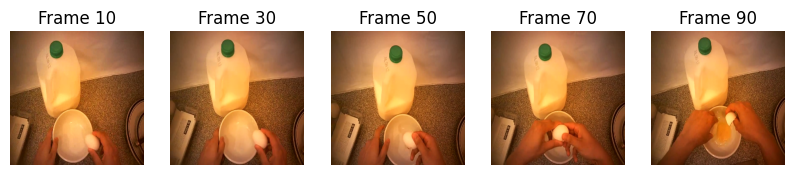

In [65]:
import cv2
import torch
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# Load video using OpenCV
# video_path = "/content/TurkeySandwich/OP01-R02-TurkeySandwich-222550-230370-F005323-F005547.mp4"
# video_path = "/content/Pizza/OP02-R07-Pizza-656144-660480-F015737-F015862.mp4"
# video_path = "/content/PastaSalad/OP01-R01-PastaSalad-898221-903011-F021546-F021684.mp4"
# video_path = "/content/GreekSalad/OP01-R06-GreekSalad-528560-535970-F012667-F012882.mp4"
# video_path = "/content/ContinentalBreakfast/OP02-R04-ContinentalBreakfast-410750-417750-F009842-F010042.mp4"
# video_path = "/content/Cheeseburger/OP01-R05-Cheeseburger-296430-301990-F007101-F007261.mp4"
video_path = "/content/BaconAndEggs/OP01-R03-BaconAndEggs-110060-114740-F002630-F002765.mp4"

cap = cv2.VideoCapture(video_path)

frames = []
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # Resize and convert to RGB
    frame_resized = cv2.resize(frame, (256, 256))
    frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)
    frame_count += 1
cap.release()

print("Number of frames loaded:", frame_count)

# Convert frames to tensor of shape [T, C, H, W]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
video_tensor = torch.stack([TF.to_tensor(frame).to(device) for frame in frames])
print("Video tensor shape:", video_tensor.shape)

# Visualize sample frames
plt.figure(figsize=(10, 2))
for i, frame_idx in enumerate(range(10, len(frames), 20)):
    if i >= 5:
        break
    plt.subplot(1, 5, i + 1)
    plt.imshow(frames[frame_idx])
    plt.title(f"Frame {frame_idx}")
    plt.axis('off')
plt.show()


In [66]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

# Calculate frame indices to get exactly 16 frames evenly distributed across the video
total_frames = len(frames)
# Use linspace to get 16 evenly spaced indices
# frame_indices = torch.linspace(0, total_frames-1, 16).long().tolist()
frame_indices = torch.linspace(0, 16, 16).long().tolist()

print("Frames to tokenize:", frame_indices)

# Process selected frames
tokens_list = []
with get_bf16_context(enable_bf16):
    for frame_idx in frame_indices:
        if frame_idx < video_tensor.shape[0]:  # Check if the index is valid
            # Process one frame at a time: shape [1, C, H, W]
            frame = video_tensor[frame_idx].unsqueeze(0)
            tokens = flextok.tokenize(frame)
            tokens_list.append(tokens[0])  # Each tokens is expected to be of shape [1, 256]
            torch.cuda.empty_cache()  # Clear cached memory between iterations

print(f"Tokenized {len(tokens_list)} frames: {frame_indices}")

Frames to tokenize: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16]
Tokenized 16 frames: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16]


In [67]:
# Define token counts to test
token_counts = [16, 64, 256]
# token_counts = [256]
num_frames = 16  # This is fine since you're now using exactly 16 frames

# Create a dictionary to store all reconstructed frames by token count
all_reconstructions = {}

# Process each token count
for num_tokens in token_counts:
    print(f"\n=== Reconstructing with {num_tokens} tokens per frame ===")

    # Detokenize the frames that were tokenized
    reconst_frames_list = []

    with get_bf16_context(enable_bf16):
        for i in range(num_frames):  # Simply iterate through all 16 frames
            if i < len(tokens_list):  # Make sure we have tokens for this frame
                # Extract the specified number of tokens for this frame
                token_subset = tokens_list[i][:, :num_tokens]

                # Detokenize this frame
                reconst = flextok.detokenize(
                    [token_subset],
                    timesteps=20,
                    guidance_scale=7.5,
                    perform_norm_guidance=True,
                    verbose = False
                )
                # reconst is a tensor of shape [1, C, H, W]; extract the image
                reconst_frames_list.append(reconst[0])
                torch.cuda.empty_cache()  # Clear cached GPU memory
                print(f"Finished detokenizing frame {i+1}/{num_frames} with {num_tokens} tokens")

    # Stack the reconstructed frames together
    reconst_frames = torch.stack(reconst_frames_list)
    print(f"Reconstructed {reconst_frames.shape[0]} frames with {num_tokens} tokens.")

    # Store in our dictionary with token count as key
    all_reconstructions[num_tokens] = reconst_frames

    # Display the results
    batch_to_pil(reconst_frames)

    # Now you can access reconstructions by token count
    # Example: all_reconstructions[1] for 1-token reconstructions
    # Example: all_reconstructions[4] for 4-token reconstructions

print("\nAll reconstructions completed and stored!")
print(f"Available token counts: {list(all_reconstructions.keys())}")


=== Reconstructing with 16 tokens per frame ===
Finished detokenizing frame 1/16 with 16 tokens
Finished detokenizing frame 2/16 with 16 tokens
Finished detokenizing frame 3/16 with 16 tokens
Finished detokenizing frame 4/16 with 16 tokens
Finished detokenizing frame 5/16 with 16 tokens
Finished detokenizing frame 6/16 with 16 tokens
Finished detokenizing frame 7/16 with 16 tokens
Finished detokenizing frame 8/16 with 16 tokens
Finished detokenizing frame 9/16 with 16 tokens
Finished detokenizing frame 10/16 with 16 tokens
Finished detokenizing frame 11/16 with 16 tokens
Finished detokenizing frame 12/16 with 16 tokens
Finished detokenizing frame 13/16 with 16 tokens
Finished detokenizing frame 14/16 with 16 tokens
Finished detokenizing frame 15/16 with 16 tokens
Finished detokenizing frame 16/16 with 16 tokens
Reconstructed 16 frames with 16 tokens.

=== Reconstructing with 64 tokens per frame ===
Finished detokenizing frame 1/16 with 64 tokens
Finished detokenizing frame 2/16 with 6

## Display Detokenize

### Grid figure for 16 frames at original, 16, 64, 256 tokens

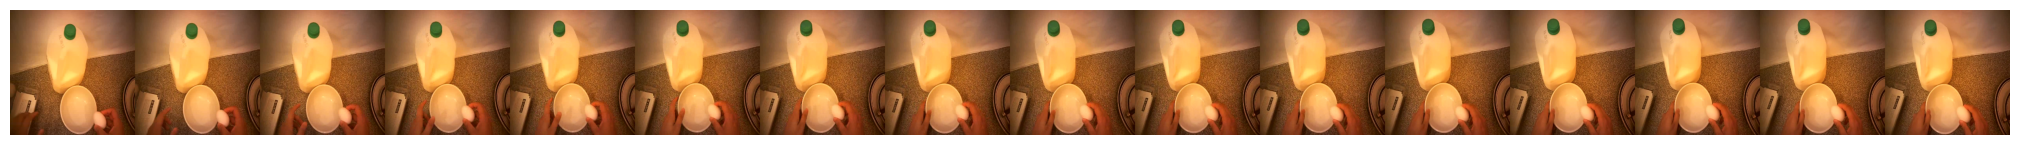

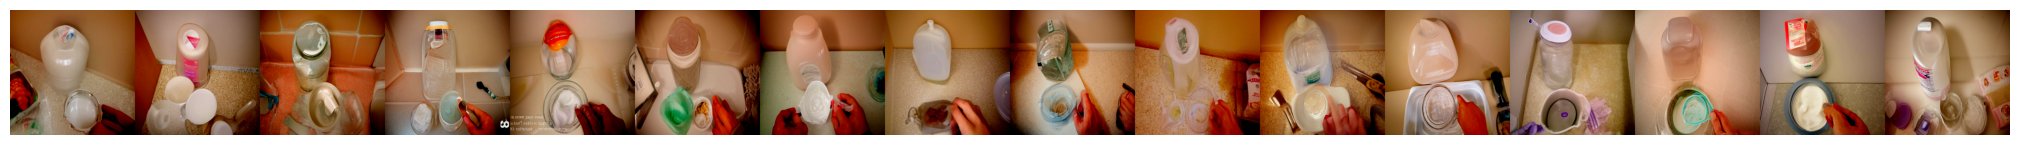

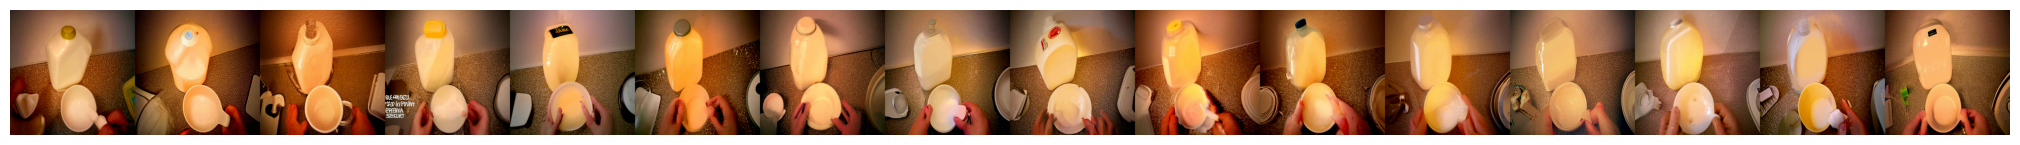

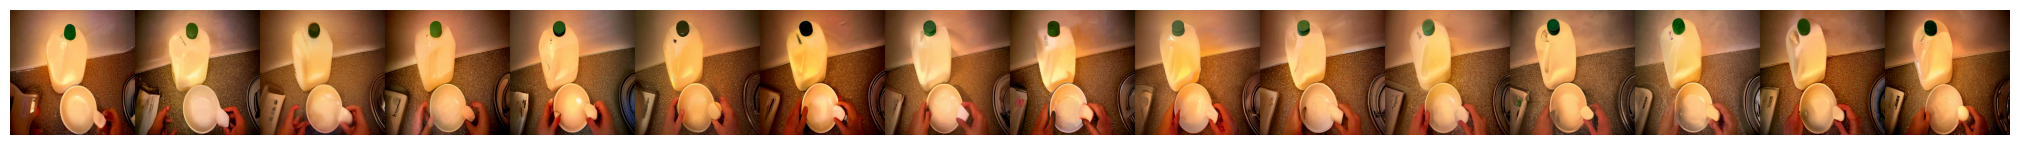

In [68]:
import torch
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def tile_frames(frames, height=256):
    """
    Resize frames to a consistent height and tile them horizontally.
    """
    resized = []
    for f in frames:
        w, h = f.size
        new_w = int(w * height / h)
        resized.append(f.resize((new_w, height)))

    total_width = sum(f.width for f in resized)
    result = Image.new("RGB", (total_width, height))

    x_offset = 0
    for f in resized:
        result.paste(f, (x_offset, 0))
        x_offset += f.width

    return result

def plot_image_row(image, title=None):
    """
    Display a single wide image.
    """
    plt.figure(figsize=(20, 4))
    if title:
        plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

def plot_original():
    original_frames = [frames[idx] for idx in frame_indices[:num_frames]]
    frame_arrays = [Image.fromarray(np.array(f)) for f in original_frames]
    tiled = tile_frames(frame_arrays)
    plot_image_row(tiled)

def plot_row(token_length=256):
    tensor = all_reconstructions[token_length]
    tensor = torch.clamp(tensor, 0, 1).cpu()
    frames = [to_pil_image(frame) for frame in tensor]
    tiled = tile_frames(frames)
    plot_image_row(tiled)

# Display
plot_original()
plot_row(16)
plot_row(64)
plot_row(256)


### GIF save

In [69]:
from PIL import Image

def save_original_gif_from_indexed_frames(frames, frame_indices, filename="original.gif", fps=5):
    """
    Convert selected frames (by index) to a GIF.

    Args:
        frames: list of PIL.Image objects (originals)
        frame_indices: list of indices (e.g., [10, 20, ..., -1])
        filename: output GIF path
        fps: frames per second
    """
    selected_frames = [frames[idx] for idx in frame_indices]
    frame_arrays = [Image.fromarray(np.array(f)) for f in selected_frames]

    duration = int(1000 / fps)
    frame_arrays[0].save(
        filename,
        save_all=True,
        append_images=frame_arrays[1:],
        duration=duration,
        loop=0
    )
    print(f"✅ Saved original GIF to: {os.path.abspath(filename)}")
save_original_gif_from_indexed_frames(
    frames=frames,
    frame_indices=frame_indices[:num_frames],
    filename="/content/TurkeySandwich/original.gif",
    fps=3
)

✅ Saved original GIF to: /content/TurkeySandwich/original.gif


In [70]:
import torch
from torchvision.transforms.functional import to_pil_image
import os

def save_reconstruction_gif(tensor, filename="reconstruction.gif", fps=5):
    """
    Converts a [T, 3, H, W] tensor to a GIF.

    Args:
        tensor (torch.Tensor): shape [T, 3, H, W], values should be [0, 1]
        filename (str): output file path
        fps (int): frames per second in the GIF

    Returns:
        Saves a GIF file to `filename`
    """
    # Safety check: clamp values and move to CPU
    tensor = torch.clamp(tensor, 0, 1).cpu()

    # Convert each frame to PIL image
    frames = [to_pil_image(frame) for frame in tensor]

    # Compute duration in milliseconds
    duration = int(1000 / fps)

    # Save as animated GIF
    frames[0].save(
        filename,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0
    )
    print(f"✅ Saved GIF to: {os.path.abspath(filename)}")


save_reconstruction_gif(all_reconstructions[16], "/content/TurkeySandwich/reconstruction_16.gif", fps=3)
save_reconstruction_gif(all_reconstructions[64], "/content/TurkeySandwich/reconstruction_64.gif", fps=3)
save_reconstruction_gif(all_reconstructions[256], "/content/TurkeySandwich/reconstruction_256.gif", fps=3)

✅ Saved GIF to: /content/TurkeySandwich/reconstruction_16.gif
✅ Saved GIF to: /content/TurkeySandwich/reconstruction_64.gif
✅ Saved GIF to: /content/TurkeySandwich/reconstruction_256.gif


## FVD with first 16 frames Input (Update with fvd.py)

In [ ]:
import os, glob, math, torch, cv2
import torchvision.transforms.functional as TF
from fvd import get_fvd_logits, frechet_distance
from pytorch_i3d import InceptionI3d
# from flextok_hub import FlexTokFromHub, get_bf16_context  # <- your helpers

# -------------------------- configuration --------------------------
VIDEO_DIR       = "/content/Pizza/"
N_FRAMES        = 16          # use the first 16 frames
TOKENS_PER_FR   = 16         # FlexTok setting
DEVICE          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ENABLE_BF16     = torch.cuda.is_available()                # bf16 only on GPU
# -------------------------------------------------------------------

# ---------- 1. I3D backbone ---------------------------------------
i3d = InceptionI3d(400, in_channels=3).eval().to(DEVICE)
i3d.load_state_dict(torch.load('/i3d_pretrained_400.pt', map_location=DEVICE))
i3d = torch.nn.DataParallel(i3d)

# ---------- 2. FlexTok model --------------------------------------
# flextok = FlexTokFromHub.from_pretrained(
#     'EPFL-VILAB/flextok_d18_d28_dfn').to(DEVICE).eval()

# ---------- 3. helper to read + resize + tensorise 16 frames -------
def first_16_as_tensor(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < N_FRAMES and cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.resize(frame, (256, 256))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(torch.tensor(frame).permute(2, 0, 1) / 255.0)
    cap.release()

    if len(frames) < N_FRAMES:
        return None
    return torch.stack(frames)  # [T, C, H, W]

# ---------- 4. iterate over dataset -------------------------------
real_clips, recon_clips = [], []

for video_path in sorted(glob.glob(os.path.join(VIDEO_DIR, '*.mp4'))):
    vid = first_16_as_tensor(video_path)
    if vid is None: continue

    # --- tokenise & detokenise each frame (on GPU) -----------------
    tokens_per_frame = []
    with get_bf16_context(ENABLE_BF16):
        for fr in vid:  # fr: [C, H, W]
            toks = flextok.tokenize(fr.unsqueeze(0).to(DEVICE))  # [1,256]
            tokens_per_frame.append(toks[0][:, :TOKENS_PER_FR])

        reconst = torch.stack([
            flextok.detokenize([t], timesteps=20,
                               guidance_scale=7.5,
                               perform_norm_guidance=True,
                               verbose=False)[0].cpu()
            for t in tokens_per_frame
        ])  # [T, C, H, W]

    real_clips.append(vid.permute(1, 0, 2, 3))   # [C, T, H, W]
    recon_clips.append(reconst.permute(1, 0, 2, 3))

    print(f"✓ processed {os.path.basename(video_path)}")

assert real_clips, "No videos with ≥16 frames found."

# ---------- 5. stack into batches [N, C, T, H, W] ------------------
real_set  = torch.stack(real_clips)
recon_set = torch.stack(recon_clips)

# ---------- 6. compute FVD ----------------------------------------
with torch.no_grad():
    emb_real = get_fvd_logits(real_set.to('cpu'), i3d, device='cpu')
    emb_fake = get_fvd_logits(recon_set.to('cpu'), i3d, device='cpu')

fvd = frechet_distance(emb_fake.cpu(), emb_real.cpu())
print(f"\nFVD over {len(real_set)} videos (first 16 frames each): {fvd:.2f}")


✓ processed OP01-R07-Pizza-216058-223293-F005168-F005377.mp4
✓ processed OP01-R07-Pizza-225969-231439-F005410-F005568.mp4
✓ processed OP01-R07-Pizza-256160-261110-F006135-F006279.mp4
✓ processed OP01-R07-Pizza-330717-336129-F007924-F008081.mp4
✓ processed OP01-R07-Pizza-361770-367380-F008669-F008831.mp4
✓ processed OP01-R07-Pizza-381100-386480-F009133-F009289.mp4
✓ processed OP01-R07-Pizza-497940-502940-F011938-F012083.mp4
✓ processed OP01-R07-Pizza-526740-532070-F012628-F012783.mp4
✓ processed OP01-R07-Pizza-644890-650040-F015465-F015613.mp4
✓ processed OP01-R07-Pizza-725820-731650-F017405-F017574.mp4
✓ processed OP01-R07-Pizza-88220-92680-F002107-F002235.mp4
✓ processed OP02-R07-Pizza-366664-370804-F008789-F008910.mp4
✓ processed OP02-R07-Pizza-397170-402383-F009520-F009670.mp4
✓ processed OP02-R07-Pizza-448277-454705-F010743-F010928.mp4
✓ processed OP02-R07-Pizza-656144-660480-F015737-F015862.mp4

FVD over 15 videos (first 16 frames each): 59.77


In [ ]:
print(get_fvd_logits(real_set[:2], i3d, 'cpu').shape)

torch.Size([2, 1024])
